In [599]:
import pandas
import numpy
import requests
import bs4
import nose.tools
import pandas as pd
import requests
from bs4 import BeautifulSoup
from bs4 import NavigableString
import time
import random
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib
from matplotlib import cm



# TDS do NOT count as first according to Football Reference

In [445]:
URLFRONT = 'https://www.pro-football-reference.com/teams/'
URLBACK = '/2018_opp_splits.htm'

#Ravens are RAV, not BAL, HOU is HTX, TEN is OTI, IND is CLT, LAC is SDG

TEAMABREV = ['NWE', 'NYJ', 'BUF', 'MIA', 'RAV', 'PIT', 'CLE', 'CIN', 'HTX', 'OTI', 'CLT', 'JAX', 'KAN', 'SDG', 'DEN', 'RAI',
            'DAL', 'NYG', 'WAS', 'PHI', 'GNB', 'DET', 'CHI', 'MIN', 'NOR', 'CAR', 'TAM', 'ATL', 'RAM', 'SFO', 'SEA', 'CRD']


TEAMNAMES = list(NAMETOABREV.keys())

NAMETOABREV = {'Cardinals' : 'CRD', 'Falcons' : 'ATL', 'Ravens' : 'RAV', 'Bills' : 'BUF', 'Panthers' : 'CAR', 'Bears' : 'CHI',
               'Bengals' : 'CIN', 'Browns' : 'CLE', 'Cowboys' : 'DAL', 'Broncos' : 'DEN', 'Lions' : 'DET', 'Packers' : 'GNB', 
               'Texans' : 'HTX', 'Colts' : 'CLT', 'Jaguars' : 'JAX', 'Chiefs' : 'KC', 'Dolphins' : 'MIA', 'Vikings' : 'MIN',
               'Patriots' : 'NWE', 'Saints' : 'NOR', 'Giants' : 'NYG', 'Jets' : 'NYJ', 'Raiders' : 'RAI', 'Eagles' : 'PHI',
               'Steelers' : 'PIT', 'Chargers' : 'SDG', '49ers' : 'SFO', 'Seahawks' : 'SEA', 'Rams' : 'RAM', 'Buccaneers' : 'TAM',
               'Titans' : 'OTI', 'Redskins' : 'WAS'}

catOptions = ['10+', '7-9', '4-6', '0-3']




In [446]:
def getHTML(teamAbrev, low, high):
    urlA = 'https://www.pro-football-reference.com/play-index/play_finder.cgi?request=1&match=summary_all&year_min=2018&year_max=2018&team_id=&opp_id='
    urlB = '&game_type=R&playoff_round=&game_num_min=0&game_num_max=99&week_num_min=0&week_num_max=99&tr_gtlt=lt&ytg_gtlt=gt&yds_to_go=&yg_gtlt=gt&yards=&is_first_down=-1&fp_gtlt=gt&fp_tm_opp=team&fp_ydline=&type=PASS&type=RUSH&is_turnover=-1&is_scoring=-1&no_play=0&game_day_of_week=&game_result=&order_by=yards&down=3&yds_to_go_min='
    urlC = '&yds_to_go_max='
    properURL = urlA + teamAbrev + urlB + str(low) + urlC + str(high)
    page = requests.get(properURL, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'})
    soup = BeautifulSoup(page.content, "html5lib")
    soup2 = soup.find('table', {'id' : 'all_plays'})
    comment = soup.find(text=lambda x: isinstance(x, NavigableString) and "all_plays" in x)
    tables = soup.find('table', {'id' : 'all_plays'})
#     print((tables))
#     print(comment)
    results = makeColumns(tables)
    return results
#     df = pd.read_sql_(tables )
    
#     return df

def makeColumns(tableAsHTML):
    headers = list()
    asHTML = tableAsHTML.find_all('thead')
    
    for tr in asHTML:
        i = 0
        content = list(tr.contents[1])[1:28:2]
        for th in content:
            headers.append(th.contents[0])    
    body = tableAsHTML.find('tbody')
    rows = body.find_all('tr')
    data = list()
    for currRow in rows:
        date = currRow.find('th')
        date = (date.contents[0].contents[0])
        values = currRow.find_all('td')
        row = list()
        row.append(date)
        for currValue in values:
#             try:
#                 value = currValue.contents[0]                
#             except IndexError:
#                 value = 0
            row.append(currValue.getText())
        data.append(row)
    df = pandas.DataFrame(data=data, columns=headers)
    return df.replace('',0)

def determineAndGoal(defense, yardline, toGo):
#     print('defense: ', defense, 'toGo', toGo, 'yardline: ', yardline, 'type: ', type(yardline[4:]), 'type2: ', type(toGo))
    if (NAMETOABREV[defense].lower() == yardline[:3].lower() and int(toGo) >= int(yardline[4:])):
        return True
    return False

def buildBigTable():
    df = getHTML(TEAMABREV[0], 0, 3)
    for team in TEAMABREV[1:]:
        print(team)
        temp = getHTML(teamAbrev=team, low=0, high=3)
        time.sleep(2 + (random.randint(0,1000)/100))
        df = df.append(temp)
    for team in TEAMABREV:
        print(team)
        temp = getHTML(teamAbrev=team, low=4, high=6)
        time.sleep(2 + (random.randint(0,1000)/100))
        df = df.append(temp)
    for team in TEAMABREV:
        print(team)
        temp = getHTML(teamAbrev=team, low=7, high=9)
        time.sleep(2 + (random.randint(0,1000)/100))
        df = df.append(temp)
    for team in TEAMABREV:
        print(team)
        temp = getHTML(teamAbrev=team, low=10, high=99)
        time.sleep(2 + (random.randint(0,1000)/100))
        df = df.append(temp)
    return df


def rowIsValid(row):
    detail = row['Detail']
    # and goal situations could skew data
    if row['AndGoal'] == True:
        return 'False'
    #dropped the first letter because of capitalization issues. also, if the numbers are equal it means the original play stands
    if detail.count('enalty') <= detail.count('eclined'):
        return 'True'
    # if the diff is negative that means it was an offensive penalty which means the defense got a win 
    if row['Diff'] < 0:
        return 'True'
    if row['Diff'] == 0:
        return 'False'
    return 'check'


def evaluateFirst(row):
    if row['Yds'] >= row['ToGo']:
        return 'first'
    else:
        return 'fourth'
    



def handle(row):
    detail = row['Detail'].lower()
    if row['AndGoal'] == True:
        return 'drop'
    if row['Diff'] == 0:
        return 'drop'
    if detail.count('penalty') <= detail.count('declined'):
        return evaluateFirst(row)
    if row['NoPenalty'] == 'True':
        return evaluateFirst(row)
    if row['Diff'] < 0:
        return 'fourth'
    if detail.count('penalty') == 1:
        if detail.count('defensive holding') > 0:
            return 'first'
        elif detail.count('defensive pass interference') > 0:
            return 'first'
        elif detail.count('illegal use of hands') > 0:
            return 'first'
        elif detail.count('roughing the passer') > 0:
            return 'first'
        elif detail.count('illegal contact') > 0:
            return 'first'
        elif detail.count('face mask') > 0:
            return 'first'
        elif detail.count('horse collar') > 0:
            return 'first'
        elif detail.count('offensive holding') > 0:
            return 'fourth'
        elif detail.count('illegal blindside block') > 0:
            return 'fourth'
        
        elif detail.count('defensive offside') > 0:
            if row['ToGo'] <= 5:
                return 'first'
            elif row['Yds'] >= row['ToGo']:
                return 'first'
            else:
                return 'drop'
             
        elif detail.count('neutral zone infraction') > 0:
            if row['ToGo'] <= 5:
                return 'first'
            elif row['Yds'] >= row['ToGo']:
                return 'first'
            else:
                return 'drop'
            
        elif detail.count('defensive too many') > 0:
            if row['ToGo'] <= 5:
                return 'first'
            elif row['Yds'] >= row['ToGo']:
                return 'first'
            else:
                return 'drop'
            
        if detail.count('unnecessary roughness') > 0:
            return evaluateFirst(row)
        if detail.count('unsportsmanlike conduct') > 0:
            return evaluateFirst(row)
        if detail.count('taunting') > 0:
            return evaluateFirst(row)
        
        elif detail.count('disqual') > 0:
            return 'drop'
        
    elif detail.count('penalty') == 2:
        return 'first'    
    elif detail.count('penalty') > 2:
        return 'drop'
    return 'drop'






def makeHorizontalDF():
    mainData = list()
    for currTeam in TEAMNAMES:
        filtered = bigBoi[(bigBoi.Handled != 'drop') & (bigBoi.Opp == currTeam)]
        totPlays = len(filtered.index)
        catDict = Counter(filtered.Category)
        currRow = list()
        currRow.append(currTeam)
        for cat in catOptions:
            temp2 = filtered[(filtered.Category == cat)]
            currTeamDict = Counter(temp2.Category)
            currRow.append((currTeamDict[cat]/totPlays)*100)
        mainData.append(currRow)
    tempDF = pandas.DataFrame(columns=['TEAM', '10+', '7-9', '4-6', '0-3'], data=mainData)
    return tempDF


    

In [196]:
bigBoi = buildBigTable()
bigBoi

NYJ
BUF
MIA
RAV
PIT
CLE
CIN
HTX
OTI
CLT
JAX
KAN
SDG
DEN
RAI
DAL
NYG
WAS
PHI
GNB
DET
CHI
MIN
NOR
CAR
TAM
ATL
RAM
SFO
SEA
CRD
NWE
NYJ
BUF
MIA
RAV
PIT
CLE
CIN
HTX
OTI
CLT
JAX
KAN
SDG
DEN
RAI
DAL
NYG
WAS
PHI
GNB
DET
CHI
MIN
NOR
CAR
TAM
ATL
RAM
SFO
SEA
CRD
NWE
NYJ
BUF
MIA
RAV
PIT
CLE
CIN
HTX
OTI
CLT
JAX
KAN
SDG
DEN
RAI
DAL
NYG
WAS
PHI
GNB
DET
CHI
MIN
NOR
CAR
TAM
ATL
RAM
SFO
SEA
CRD
NWE
NYJ
BUF
MIA
RAV
PIT
CLE
CIN
HTX
OTI
CLT
JAX
KAN
SDG
DEN
RAI
DAL
NYG
WAS
PHI
GNB
DET
CHI
MIN
NOR
CAR
TAM
ATL
RAM
SFO
SEA
CRD


,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff
0,2018-10-14,Chiefs,Patriots,3,13:39,3,2,KAN 33,15-24,Patrick Mahomes pass complete deep right to Ka...,67,0.430,7.000,6.57
1,2018-11-04,Packers,Patriots,3,1:04,3,1,GNB 16,17-17,Aaron Rodgers pass complete deep right to Marq...,24,-0.370,1.600,1.97
2,2018-10-29,Bills,Patriots,3,13:36,3,3,BUF 18,3-9,Derek Anderson pass complete short left to LeS...,18,-0.600,0.340,.94
3,2018-10-04,Colts,Patriots,2,11:13,3,1,CLT 34,0-14,Andrew Luck pass complete short left to Eric E...,17,0.560,2.320,1.76
4,2018-11-25,Jets,Patriots,1,4:08,3,3,NWE 16,6-0,Josh McCown pass complete short middle to Jerm...,16,3.850,7.000,3.15
5,2018-09-30,Dolphins,Patriots,2,0:07,3,1,MIA 34,0-24,Ryan Tannehill pass complete short middle to K...,13,0.560,2.060,1.50
6,2018-11-25,Jets,Patriots,3,6:40,3,1,NYJ 49,10-13,Isaiah Crowell right end for 12 yards (tackle ...,12,1.550,2.980,1.43
7,2018-09-16,Jaguars,Patriots,3,11:00,3,2,NWE 32,21-3,Blake Bortles pass complete short right to Kee...,11,2.740,4.170,1.43
8,2018-11-11,Titans,Patriots,2,2:00,3,2,NWE 13,17-10,Marcus Mariota pass complete short left to Ant...,11,4.240,6.740,2.50
9,2018-09-30,Dolphins,Patriots,4,8:51,3,3,MIA 32,0-38,Brock Osweiler pass complete short right to Fr...,10,0.300,1.730,1.43


In [383]:
bigBoi.Quarter = bigBoi.Quarter.map(int)
bigBoi.Down = bigBoi.Down.map(int)
bigBoi.ToGo = bigBoi.ToGo.map(int)
bigBoi.Yds = bigBoi.Yds.map(int)
bigBoi.EPB = bigBoi.EPB.map(float)
bigBoi.EPA = bigBoi.EPA.map(float)
bigBoi.Diff = bigBoi.Diff.map(float)

bigBoi['AndGoal'] = bigBoi.apply(lambda x: determineAndGoal(defense=x['Opp'], toGo=x['ToGo'], yardline=x['Location']), axis=1)
bigBoi['NoPenalty'] = bigBoi.apply(lambda x: 'True' if 'Penalty' not in x['Detail'] else 'False', axis=1)
bigBoi['Valid'] = bigBoi.apply(lambda x: rowIsValid(x), axis = 1)
bigBoi['Handled'] = bigBoi.apply(lambda x: handle(x), axis = 1)
bigBoi

,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff,AndGoal,NoPenalty,Valid,Handled
0,2018-10-14,Chiefs,Patriots,3,13:39,3,2,KAN 33,15-24,Patrick Mahomes pass complete deep right to Ka...,67,0.43,7.00,6.57,False,True,True,first
1,2018-11-04,Packers,Patriots,3,1:04,3,1,GNB 16,17-17,Aaron Rodgers pass complete deep right to Marq...,24,-0.37,1.60,1.97,False,True,True,first
2,2018-10-29,Bills,Patriots,3,13:36,3,3,BUF 18,3-9,Derek Anderson pass complete short left to LeS...,18,-0.60,0.34,0.94,False,False,check,fourth
3,2018-10-04,Colts,Patriots,2,11:13,3,1,CLT 34,0-14,Andrew Luck pass complete short left to Eric E...,17,0.56,2.32,1.76,False,True,True,first
4,2018-11-25,Jets,Patriots,1,4:08,3,3,NWE 16,6-0,Josh McCown pass complete short middle to Jerm...,16,3.85,7.00,3.15,False,True,True,first
5,2018-09-30,Dolphins,Patriots,2,0:07,3,1,MIA 34,0-24,Ryan Tannehill pass complete short middle to K...,13,0.56,2.06,1.50,False,True,True,first
6,2018-11-25,Jets,Patriots,3,6:40,3,1,NYJ 49,10-13,Isaiah Crowell right end for 12 yards (tackle ...,12,1.55,2.98,1.43,False,True,True,first
7,2018-09-16,Jaguars,Patriots,3,11:00,3,2,NWE 32,21-3,Blake Bortles pass complete short right to Kee...,11,2.74,4.17,1.43,False,True,True,first
8,2018-11-11,Titans,Patriots,2,2:00,3,2,NWE 13,17-10,Marcus Mariota pass complete short left to Ant...,11,4.24,6.74,2.50,False,True,True,first
9,2018-09-30,Dolphins,Patriots,4,8:51,3,3,MIA 32,0-38,Brock Osweiler pass complete short right to Fr...,10,0.30,1.73,1.43,False,True,True,first


In [388]:
print(len(list(bigBoi[bigBoi.Handled == 'check'].Detail)))
(list(bigBoi[bigBoi.Handled == 'check'].Detail))
Counter(bigBoi.Handled)
bigBoi.to_csv('dataCleaned.csv')

0


In [301]:
bigBoi[bigBoi.Detail == 'Derek Anderson pass complete short left to LeSean McCoy for 18 yards (tackle by Stephon Gilmore). Penalty on Kelvin Benjamin: Illegal Blindside Block, 15 yards']

,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff,AndGoal,NoPenalty,Valid,Handled
2,2018-10-29,Bills,Patriots,3,13:36,3,3,BUF 18,3-9,Derek Anderson pass complete short left to LeS...,18,-0.6,0.34,0.94,False,False,check,check


In [292]:
#compute averages
#ranges are 1-3, 4-6, 7-9, 10+

#conversion rates:
ConversionRates = []

We want to ignore the plays if there were offsetting penalties (diff = 0) or if it is and-goal

The play should definitely be viewed if there were no penalties or if declined = penalties


if diff is negative, it is an offensive penalty.You can safely count that play too, but make a note that it is not a first down 


The concern is where the yards gained is not accurate because of penalties on the defense.






Make a function that takes 2 numbers (yards, to go) and determines if it WOULD be a first. make confusing if structure that shifts thtough possibilities. outside of structure, return "check" or something so you know to look closer at those. Assign other values as first down, not a first, drop (ignore the play)

In [396]:
def categorize(distance):
    if distance <= 3:
        return '0-3'
    elif distance <= 6:
        return '4-6'
    elif distance <= 9:
        return '7-9'
    else:
        return '10+'

categories = bigBoi.apply(lambda x: categorize(x['ToGo']), axis=1)
bigBoi['Category'] = categories


eagles = bigBoi[bigBoi.Opp == 'Eagles']
for cat in catOptions:
    print (cat, len(list(eagles[eagles.Category == cat].Category)) / 210)
    
eagles[eagles.Category == '10+']




0-3 0.2857142857142857
4-6 0.1619047619047619
7-9 0.1761904761904762
10+ 0.3761904761904762


,Date,Tm,Opp,Quarter,Time,Down,ToGo,Location,Score,Detail,Yds,EPB,EPA,Diff,AndGoal,NoPenalty,Valid,Handled,Category
0,2018-12-23,Texans,Eagles,4,2:11,3,11,PHI 35,29-29,Deshaun Watson pass complete deep left to Vync...,35,1.95,7.00,5.05,False,True,True,first,10+
1,2018-09-06,Falcons,Eagles,1,13:01,3,10,PHI 39,0-0,Matt Ryan pass complete deep left to Julio Jon...,33,1.75,5.83,4.08,False,True,True,first,10+
2,2018-12-16,Rams,Eagles,4,4:19,3,10,PHI 34,16-30,Jared Goff pass complete deep middle to Josh R...,33,2.08,6.97,4.89,False,True,True,first,10+
3,2018-11-11,Cowboys,Eagles,2,0:58,3,15,DAL 35,6-3,Dak Prescott pass complete short left to Micha...,25,-0.30,2.92,3.22,False,True,True,first,10+
4,2018-12-23,Texans,Eagles,4,3:25,3,11,HTX 44,23-29,Deshaun Watson pass complete deep left to Jord...,22,0.56,3.31,2.75,False,True,True,first,10+
5,2018-09-06,Falcons,Eagles,4,1:25,3,17,PHI 40,12-18,Matt Ryan pass complete deep left to Julio Jon...,18,1.22,4.11,2.89,False,True,True,first,10+
6,2018-10-11,Giants,Eagles,4,6:49,3,16,PHI 29,13-34,Eli Manning pass complete short right to Wayne...,18,2.01,4.84,2.83,False,True,True,first,10+
7,2018-09-30,Titans,Eagles,5,2:00,3,19,PHI 49,20-23,Marcus Mariota middle for 17 yards (tackle by ...,17,0.50,1.30,0.80,False,True,True,fourth,10+
8,2018-10-28,Jaguars,Eagles,2,3:32,3,21,JAX 46,3-3,Blake Bortles pass complete short right to T.J...,15,0.04,0.66,0.62,False,True,True,fourth,10+
9,2018-12-09,Cowboys,Eagles,2,2:20,3,13,PHI 18,3-0,Dak Prescott left end for 15 yards (tackle by ...,15,2.89,1.62,-1.27,False,False,True,fourth,10+


array([  0,  20,  40,  60,  80, 100])

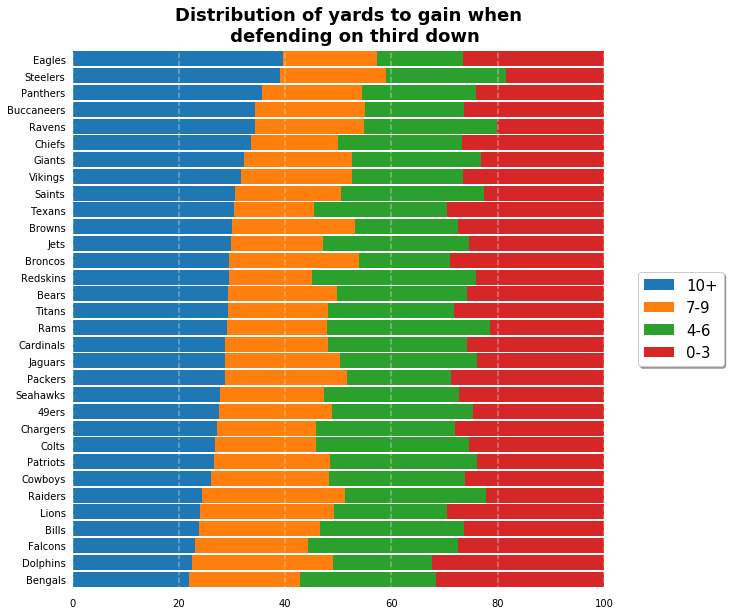

In [485]:
horizontalDF = makeHorizontalDF()
horizontalDF = horizontalDF.sort_values(ascending=True, by='10+')
horizontalDF.index = horizontalDF.TEAM

ax = horizontalDF.plot(kind='barh', stacked=True, width=.9, figsize=(10,10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)
ax.set_xticks([0,20,40,60,80,100])
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    

  # Set y-axis label
ax.set_ylabel("", labelpad=20, weight='bold', size=12)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, prop={'size': 15})

ax.set_title('Distribution of yards to gain when \n defending on third down',loc='Center', fontsize=18, fontweight='bold')

vals




# https://mode.com/example-gallery/python_horizontal_bar/

In [572]:
def makeConversionRateDF():
    mainData = list()
    byDistDescending = list()
    for cat in catOptions:
        temp = bigBoi[(bigBoi.Handled != 'drop') & (bigBoi.Category == cat)]
        byDistDescending.append(len(temp[temp.Handled=='first'].index) / len(temp.index) * 100)
    for currTeam in TEAMNAMES:
        filtered = bigBoi[(bigBoi.Handled != 'drop') & (bigBoi.Opp == currTeam)]
        totPlays = len(filtered.index)
        catDict = Counter(filtered.Category)
        currRow = list()
        currRow.append(currTeam)
        for index, cat in enumerate(catOptions):
            temp2 = filtered[(filtered.Category == cat)]
            outComeDict = Counter(temp2.Handled)
            teamPercent = (outComeDict['first']/len(temp2.index))*100
            currRow.append(byDistDescending[index] - teamPercent)
        mainData.append(currRow)
    tempDF = pandas.DataFrame(columns=['TEAM', '10+', '7-9', '4-6', '0-3'], data=mainData)
    return tempDF

conversionDF = makeConversionRateDF()
# conversionDF.index = conversionDF.TEAM
conversionDF = conversionDF.sort_values(by='10+', ascending=False, axis=0)
conversionDF

eaglesConversion = conversionDF[conversionDF.TEAM == 'Eagles']
eaglesConversion

bsDF = pandas.DataFrame({'numbers' : [10,20,-15,8]})
bsDF.index = catOptions
bsDF

,numbers
10+,10
7-9,20
4-6,-15
0-3,8


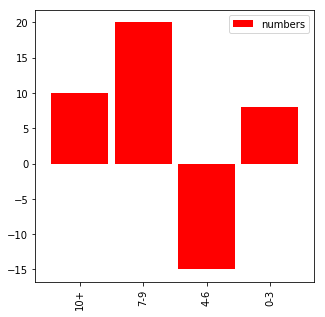

In [612]:

# print(eaglesConversion.columns)
# print(list(eaglesConversion.iloc[0:,]))

# from  matplotlib.colors import LinearSegmentedColormap
# c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
# v = [0,.15,.4,.5,0.6,.9,1.]
# l = list(zip(v,c))
# cmap=LinearSegmentedColormap.from_list('rg',l, N=256)



ax2= bsDF.plot.bar(width = .9, figsize=(5,5), color='R')


# # # ax2 = horizontalDF.plot(kind='barh', stacked=True, width=.9, figsize=(10,10))

# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)

# ax2.tick_params(axis="both", which="both", bottom=True, top=False, labelbottom=True, left=False, right=False, labelleft=True)
# ax2.get_legend().remove()
# ax2.set_xticklabels(['a', 'b', 'c', 'd'])
# ax2.set_yticks(range(-20,25,5))
# vals = ax2.get_yticks()
# # for tick in vals:
# #     ax2.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

In [525]:
conversionDF

,TEAM,10+,7-9,4-6,0-3
TEAM,,,,,
Colts,Colts,10.298392,-15.653599,0.194893,-0.315000
Vikings,Vikings,8.506278,2.831639,10.876138,2.777006
Redskins,Redskins,7.850181,-4.957504,-1.751714,-18.697353
Eagles,Eagles,6.935819,-18.904373,6.312802,1.645785
Giants,Giants,6.703621,-18.835973,-3.997129,-6.877625
Packers,Packers,6.409503,-4.688686,5.998089,8.802647
Patriots,Patriots,5.723229,3.644647,3.513045,-2.574164
Bears,Bears,4.742837,8.717111,3.204297,3.572762
Steelers,Steelers,3.460786,-3.022020,-6.088632,3.712557


AttributeError: Unknown property colormap

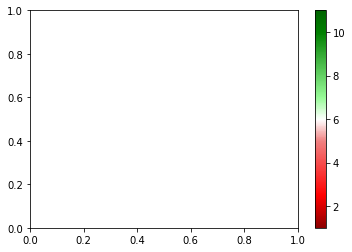

In [607]:
y = numpy.array([1, 4, 3, 2, 7, 11])
colors = cm.RdYlGn(y / float(max(y)))





plot = plt.scatter(y, y, c = y, cmap = cmap)
plt.clf()
plt.colorbar(plot)
plt.bar(range(len(y)), y, colormap = cmap)
plt.show()

[Text(0,0,'a'),
 Text(0,0,'b'),
 Text(0,0,'c'),
 Text(0,0,'d'),
 Text(0,0,'e'),
 Text(0,0,'f'),
 Text(0,0,'g'),
 Text(0,0,'h'),
 Text(0,0,'i'),
 Text(0,0,'j'),
 Text(0,0,'k')]

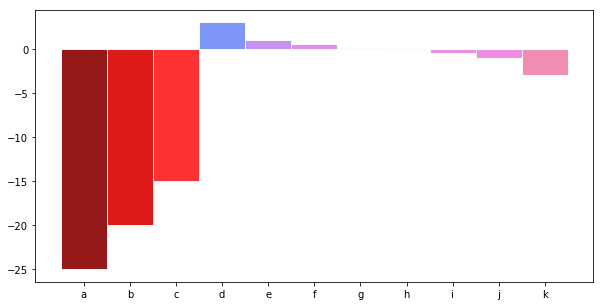

In [666]:

from  matplotlib.colors import LinearSegmentedColormap
c = ["darkred","red","lightcoral","violet", "dodgerblue","blue","navy"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

f, ax = plt.subplots(1, figsize=(10,5))
bar_width = 1
# positions of the left bar-boundaries
bar_l = [i for i in range(11)] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 


from scipy import stats
# percentile = stats.percentileofscore(arr, x)

def div10(val):
    return val/10


def testFunc(value):
    arr = list(range(-250,251,1))
    arr = list(map(div10, arr))
    val = stats.percentileofscore(arr, value)
    return cmap(val/100)
    
dumbData = [-25, -20, -15, 3, 1, .5, .1, -.1, -.5, -1, -3]

ax.bar(bar_l, 
       # using pre_rel data
       dumbData, 
       # labeled 
       label='Pre Score', 
       # with alpha
       alpha=0.9, 
       # with color
       color=list(map(testFunc, dumbData)),
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'])

In [653]:
dumbData

[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25]